# Feature Selection and Classification using Random Forest and HAC

In this notebook, the 24-hour flight data is used to conduct the classification.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
%run ../flight\ phase\ on\ dataset/db.py
df = db_to_pandas(filename='descriptors_meteo.db')
df.head()

,flight_id,airline,icao,icao_airline,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,...,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,airport_climb,temp_c_climb,dewpoint_c_climb,wind_spind_kt_climb
0,1,Global Aviation Operations,008ff4,GBB,1479.0,164.132000,62.692409,-7.088400,3.912235,250.30,...,7.977123,4.183138,252.41,73.37,20.16,0.00,None,NaN,NaN,NaN
1,2,Global Aviation Operations,008ff4,GBB,1360.0,173.656721,48.117567,-8.526885,3.483607,227.50,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
2,3,Global Aviation Operations,008ff4,GBB,1230.0,167.556087,54.456395,-9.011304,4.909492,235.97,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
3,4,Global Aviation Operations,008ff4,GBB,1130.0,167.244324,54.202158,-9.560270,4.882914,234.84,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
4,5,Global Aviation Operations,008ff4,GBB,1720.0,155.548214,63.154879,-6.169405,3.517790,250.64,...,7.802778,3.930737,259.13,64.39,17.88,-0.33,None,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11538 entries, 0 to 11537
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   flight_id                   11538 non-null  int64  
 1   airline                     11263 non-null  object 
 2   icao                        11538 non-null  object 
 3   icao_airline                11538 non-null  object 
 4   duration_descent            6382 non-null   float64
 5   avg_speed_descent           6382 non-null   float64
 6   std_speed_descent           6382 non-null   float64
 7   avg_vertrate_speed_descent  6382 non-null   float64
 8   std_vertrate_speed_descent  6382 non-null   float64
 9   max_spd_descent             6382 non-null   float64
 10  min_spd_descent             6382 non-null   float64
 11  max_vertrate_speed_descent  6382 non-null   float64
 12  min_vertrate_speed_descent  6382 non-null   float64
 13  airport_descent             104

<AxesSubplot:>

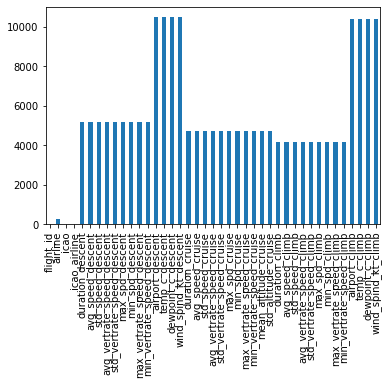

In [4]:
# The number of null values
df.isna().sum().plot(kind='bar')

In [5]:
df.drop(columns=['icao', 'icao_airline', 'duration_descent', 'duration_cruise', 'duration_climb', 'airport_climb', 'airport_descent'],inplace=True)

In [6]:
df.dropna(subset = ['airline'], inplace = True)

In [7]:
df['airline'].value_counts()

Air France                           1374
Aeroflot Russian Airlines            1010
Rossiya                               746
Turkish Airlines                      701
Volaris                               576
                                     ... 
Iran Air                                1
Binter Canarias                         1
Turkish Airlines General Aviation       1
Beijing Capital Airlines                1
Angkor Air                              1
Name: airline, Length: 119, dtype: int64

In [8]:
# Here categorical codes are added in the dataframe for airlines
df["airline"] = df["airline"].astype('category')
df["airline_cat"]=df["airline"].cat.codes
df_noairline = df.drop(columns=['airline'])
df_noairline.set_index('flight_id',inplace=True)
df_noairline.head()

,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,min_vertrate_speed_descent,temp_c_descent,dewpoint_c_descent,...,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,temp_c_climb,dewpoint_c_climb,wind_spind_kt_climb,airline_cat
flight_id,,,,,,,,,,,,,,,,,,,,,
1,164.132000,62.692409,-7.088400,3.912235,250.30,75.76,0.33,-16.26,NaN,NaN,...,7.977123,4.183138,252.41,73.37,20.16,0.00,NaN,NaN,NaN,52
2,173.656721,48.117567,-8.526885,3.483607,227.50,63.46,-2.60,-21.13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
3,167.556087,54.456395,-9.011304,4.909492,235.97,62.27,0.33,-19.83,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
4,167.244324,54.202158,-9.560270,4.882914,234.84,61.95,-1.63,-20.48,23.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
5,155.548214,63.154879,-6.169405,3.517790,250.64,73.77,0.00,-14.31,NaN,NaN,...,7.802778,3.930737,259.13,64.39,17.88,-0.33,NaN,NaN,NaN,52


In [9]:
# The dictionary of airline and their codes
airlines_decoder = dict(enumerate(df["airline"].cat.categories))

In [10]:
df_noairline.describe()

,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,min_vertrate_speed_descent,temp_c_descent,dewpoint_c_descent,...,avg_vertrate_speed_climb,std_vertrate_speed_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,temp_c_climb,dewpoint_c_climb,wind_spind_kt_climb,airline_cat
count,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000,1026.000000,1026.000000,...,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,1117.000000,1117.000000,1117.000000,11263.000000
mean,155.432029,51.311277,-7.581051,7.200145,225.490411,70.876099,-0.329963,-40.557510,3.011014,-0.446004,...,10.133301,7.540315,234.183098,77.481243,40.076988,1.349547,3.129185,-0.104297,8.246195,58.311462
std,18.951226,11.994864,4.352093,19.416473,31.301989,19.526216,1.077078,127.455623,11.937310,11.292624,...,5.062158,20.289679,23.909701,15.569619,118.313990,1.807393,11.728595,10.917943,5.098430,40.364383
min,62.109583,0.000000,-108.208000,0.000000,66.150000,0.000000,-11.050000,-1678.310000,-29.000000,-34.000000,...,3.387368,0.000000,82.440000,0.000000,5.530000,-33.160000,-26.000000,-30.000000,0.000000,0.000000
25%,142.524179,44.652905,-7.786267,2.998407,211.170000,61.200000,-0.330000,-19.830000,-6.000000,-9.000000,...,8.238544,3.685444,219.420000,69.332500,17.560000,0.000000,-6.000000,-8.000000,4.000000,14.000000
50%,154.167273,51.210551,-6.886429,3.606299,224.480000,65.090000,0.000000,-15.610000,6.000000,4.000000,...,9.383148,4.150623,233.970000,75.620000,19.510000,0.650000,6.000000,4.000000,8.000000,65.000000
75%,167.154286,58.256858,-6.116111,4.378183,239.270000,70.450000,0.000000,-12.680000,13.000000,9.000000,...,10.660104,4.667277,247.990000,82.190000,21.780000,2.280000,13.000000,9.000000,11.000000,104.000000
max,295.265467,413.283756,-1.780000,362.994481,1774.180000,219.470000,5.850000,-1.950000,34.000000,24.000000,...,87.289167,267.706896,743.540000,167.100000,1346.840000,14.960000,34.000000,27.000000,29.000000,118.000000


In [11]:
columns = df_noairline.columns
columns

Index(['avg_speed_descent', 'std_speed_descent', 'avg_vertrate_speed_descent',
       'std_vertrate_speed_descent', 'max_spd_descent', 'min_spd_descent',
       'max_vertrate_speed_descent', 'min_vertrate_speed_descent',
       'temp_c_descent', 'dewpoint_c_descent', 'wind_spind_kt_descent',
       'avg_speed_cruise', 'std_speed_cruise', 'avg_vertrate_speed_cruise',
       'std_vertrate_speed_cruise', 'max_spd_cruise', 'min_spd_cruise',
       'max_vertrate_speed_cruise', 'min_vertrate_speed_cruise',
       'mean_altitude_cruise', 'std_altitude_cruise', 'avg_speed_climb',
       'std_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'max_spd_climb', 'min_spd_climb',
       'max_vertrate_speed_climb', 'min_vertrate_speed_climb', 'temp_c_climb',
       'dewpoint_c_climb', 'wind_spind_kt_climb', 'airline_cat'],
      dtype='object')

<div class="alert alert-block alert-warning">
<b>Hypothesis:</b> Only airlines with 10 logs or more are eligible for classification. So others will be excluded in the following analysis procedure.
</div>

In [12]:
filt_10log = df_noairline['airline_cat'].value_counts()>=10

In [13]:
airline_list_cat = filt_10log[filt_10log.values==True].index

In [14]:
df_filt_10log = df_noairline[df_noairline['airline_cat'].isin(airline_list_cat)]

In [15]:
df_filt_10log.columns

Index(['avg_speed_descent', 'std_speed_descent', 'avg_vertrate_speed_descent',
       'std_vertrate_speed_descent', 'max_spd_descent', 'min_spd_descent',
       'max_vertrate_speed_descent', 'min_vertrate_speed_descent',
       'temp_c_descent', 'dewpoint_c_descent', 'wind_spind_kt_descent',
       'avg_speed_cruise', 'std_speed_cruise', 'avg_vertrate_speed_cruise',
       'std_vertrate_speed_cruise', 'max_spd_cruise', 'min_spd_cruise',
       'max_vertrate_speed_cruise', 'min_vertrate_speed_cruise',
       'mean_altitude_cruise', 'std_altitude_cruise', 'avg_speed_climb',
       'std_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'max_spd_climb', 'min_spd_climb',
       'max_vertrate_speed_climb', 'min_vertrate_speed_climb', 'temp_c_climb',
       'dewpoint_c_climb', 'wind_spind_kt_climb', 'airline_cat'],
      dtype='object')

# Correlation between features

In [16]:
corr_matrix = df_filt_10log.corr(method='spearman')

In [17]:
(corr_matrix[(corr_matrix>0.5) | (corr_matrix<-0.5)].count().sum() - corr_matrix.columns.shape[0])/2

39.0

There exists several couples (37) of variables that are highly correlated, with a coefficient of correlation superior to 0.5. A feature selection process needs to be conducted.

In [18]:
# Standard Scaling (not necessary for random forest)
feature_selection_df = df_filt_10log.dropna()
X = feature_selection_df.iloc[:,:-1]
y = feature_selection_df.loc[:,["airline_cat"]]
X_full = df_filt_10log.iloc[:,:-1]
y_full = df_filt_10log.loc[:,["airline_cat"]]

In [19]:
# Spliting the data into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Training a random forest classifier 
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

clf.fit(X_train, y_train)


<ipython-input-19-982bd971965e>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [20]:
# Print the name and gini importance of each feature
columns = df_filt_10log.columns
for feature in zip(columns, clf.feature_importances_):
    print(feature)

('avg_speed_descent', 0.031123702594285582)
('std_speed_descent', 0.02273827780096147)
('avg_vertrate_speed_descent', 0.04687627333608266)
('std_vertrate_speed_descent', 0.04715177748246019)
('max_spd_descent', 0.02943077310351173)
('min_spd_descent', 0.029470730731018274)
('max_vertrate_speed_descent', 0.01568856591599216)
('min_vertrate_speed_descent', 0.04371285848983102)
('temp_c_descent', 0.05600044976746809)
('dewpoint_c_descent', 0.04684678458047632)
('wind_spind_kt_descent', 0.018504280326862303)
('avg_speed_cruise', 0.027548833012001957)
('std_speed_cruise', 0.029570103589350222)
('avg_vertrate_speed_cruise', 0.02258323154013404)
('std_vertrate_speed_cruise', 0.023628567682310957)
('max_spd_cruise', 0.023912999088205475)
('min_spd_cruise', 0.037126482936769706)
('max_vertrate_speed_cruise', 0.01385154811852098)
('min_vertrate_speed_cruise', 0.011581050936627474)
('mean_altitude_cruise', 0.0524466000794111)
('std_altitude_cruise', 0.02942297297258482)
('avg_speed_climb', 0.0321

In [21]:
len(clf.feature_importances_), len(columns)

(32, 33)

<BarContainer object of 32 artists>

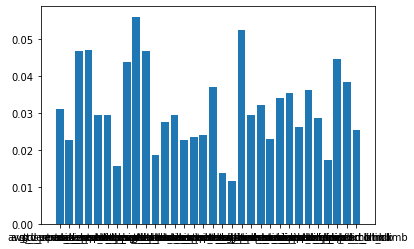

In [22]:
plt.bar(columns[:-1],clf.feature_importances_)

In [23]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 1.5 times median

sfm = SelectFromModel(clf, threshold=np.median(clf.feature_importances_))

# Train the selector
sfm.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:224: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestClassifier(n_estimators=10000, n_jobs=-1,
                                                 random_state=0),
                threshold=0.029450751917265004)

In [24]:
# Print the names of the most important features
i = 0
for feature_list_index in sfm.get_support(indices=True):
    print(columns[feature_list_index])
    i += 1
print(f'The number of columns chosen is {i}')

avg_speed_descent
avg_vertrate_speed_descent
std_vertrate_speed_descent
min_spd_descent
min_vertrate_speed_descent
temp_c_descent
dewpoint_c_descent
std_speed_cruise
min_spd_cruise
mean_altitude_cruise
avg_speed_climb
avg_vertrate_speed_climb
std_vertrate_speed_climb
min_spd_climb
temp_c_climb
dewpoint_c_climb
The number of columns chosen is 16


In [25]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [26]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

<ipython-input-26-2862a864be5a>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_important.fit(X_important_train, y_train)


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [27]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
accuracy_score(y_test, y_pred)

0.46923076923076923

In [28]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)

0.49230769230769234

In [29]:
# Transform all data
selection = sfm.get_support()
X_columns = columns[:-1]
columns_remained = X_columns[selection]

In [30]:
X_full_selected = X_full[columns_remained]

In [31]:
X_full_selected

,avg_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,min_spd_descent,min_vertrate_speed_descent,temp_c_descent,dewpoint_c_descent,std_speed_cruise,min_spd_cruise,mean_altitude_cruise,avg_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,min_spd_climb,temp_c_climb,dewpoint_c_climb
flight_id,,,,,,,,,,,,,,,,
1,164.132000,-7.088400,3.912235,75.76,-16.26,NaN,NaN,0.307581,243.97,11887.424118,207.304110,7.977123,4.183138,73.37,NaN,NaN
2,173.656721,-8.526885,3.483607,63.46,-21.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,167.556087,-9.011304,4.909492,62.27,-19.83,NaN,NaN,1.546341,216.32,10971.657000,NaN,NaN,NaN,NaN,NaN,NaN
4,167.244324,-9.560270,4.882914,61.95,-20.48,23.0,16.0,0.847364,215.97,10973.525714,NaN,NaN,NaN,NaN,NaN,NaN
5,155.548214,-6.169405,3.517790,73.77,-14.31,NaN,NaN,NaN,NaN,NaN,206.172917,7.802778,3.930737,64.39,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.241111,7.267222,4.167291,83.75,21.0,13.0
11535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.377500,8.695714,4.629653,90.70,NaN,NaN
11536,150.332436,-5.053077,3.101744,65.57,-14.96,NaN,NaN,1.239543,222.88,8870.026364,185.659524,9.490000,4.674674,83.33,NaN,NaN


# Aggregating data

In [32]:
y_full

,airline_cat
flight_id,
1,52
2,52
3,52
4,52
5,52
...,...
11534,40
11535,40
11536,40


In [33]:
new_df = pd.merge(X_full_selected, y_full, how = 'left', left_index = True, right_index = True)

In [34]:
new_df

,avg_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,min_spd_descent,min_vertrate_speed_descent,temp_c_descent,dewpoint_c_descent,std_speed_cruise,min_spd_cruise,mean_altitude_cruise,avg_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,min_spd_climb,temp_c_climb,dewpoint_c_climb,airline_cat
flight_id,,,,,,,,,,,,,,,,,
1,164.132000,-7.088400,3.912235,75.76,-16.26,NaN,NaN,0.307581,243.97,11887.424118,207.304110,7.977123,4.183138,73.37,NaN,NaN,52
2,173.656721,-8.526885,3.483607,63.46,-21.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
3,167.556087,-9.011304,4.909492,62.27,-19.83,NaN,NaN,1.546341,216.32,10971.657000,NaN,NaN,NaN,NaN,NaN,NaN,52
4,167.244324,-9.560270,4.882914,61.95,-20.48,23.0,16.0,0.847364,215.97,10973.525714,NaN,NaN,NaN,NaN,NaN,NaN,52
5,155.548214,-6.169405,3.517790,73.77,-14.31,NaN,NaN,NaN,NaN,NaN,206.172917,7.802778,3.930737,64.39,NaN,NaN,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.241111,7.267222,4.167291,83.75,21.0,13.0,40
11535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.377500,8.695714,4.629653,90.70,NaN,NaN,40
11536,150.332436,-5.053077,3.101744,65.57,-14.96,NaN,NaN,1.239543,222.88,8870.026364,185.659524,9.490000,4.674674,83.33,NaN,NaN,40


In [35]:
df_median = new_df.groupby(by = 'airline_cat').median()

In [36]:
df_median.dropna(inplace=True)

In [37]:
df_median.columns

Index(['avg_speed_descent', 'avg_vertrate_speed_descent',
       'std_vertrate_speed_descent', 'min_spd_descent',
       'min_vertrate_speed_descent', 'temp_c_descent', 'dewpoint_c_descent',
       'std_speed_cruise', 'min_spd_cruise', 'mean_altitude_cruise',
       'avg_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'min_spd_climb', 'temp_c_climb',
       'dewpoint_c_climb'],
      dtype='object')

In [38]:
df_median_values = df_median.values
scaler = RobustScaler().fit(df_median_values)
df_median_scaled = scaler.fit_transform(df_median_values)
df_median_scaled = pd.DataFrame(df_median_scaled)

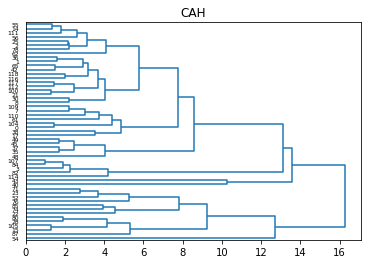

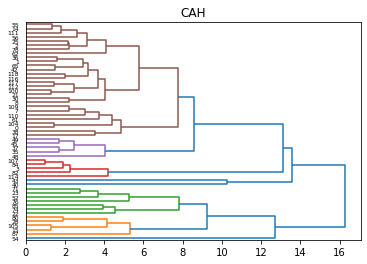

In [39]:
Z = linkage(df_median_scaled,method='ward',metric='euclidean')
threshold = 8
plt.title("CAH")
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=0)
plt.show()
plt.title('CAH')
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=threshold)
plt.show()

In [40]:
import numpy as np
import pandas
groupes_cah = fcluster(Z,t=threshold,criterion='distance')
print(groupes_cah)

[8 8 8 6 8 8 8 1 8 8 2 2 8 1 8 7 8 7 8 4 8 5 7 7 7 2 3 8 8 8 8 8 2 2 2 8 1
 6 6 2 1 8 8 1 6 8 8 8 8 6 8 8 8]


In [41]:
idg = np.argsort(groupes_cah)
df1 = pandas.DataFrame(df_median.index[idg],groupes_cah[idg])
df2 = pd.DataFrame.from_dict(airlines_decoder, orient='index')

In [42]:
pd.merge(df1, df2, how = 'left', left_on = 'airline_cat', right_index = True)

,airline_cat,0
1,80,Qatar Airways
1,87,Saudia
1,15,Air Fret Senegal
1,28,Asiana Airlines
1,105,Turkish Airlines
2,71,Nepal Airlines
2,76,Pakistan International Airlines
2,52,Global Aviation Operations
2,85,SATA International
2,74,Olympic Air


In [57]:
df_median['group'] = groupes_cah
df_median_scaled['group'] = groupes_cah
df_median_scaled.groupby('group').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
group,,,,,,,,,,,,,,,,
1,-0.038290,1.090370,-1.183839,0.357814,0.909231,0.460000,0.228571,-0.345964,0.651107,-2.037764,0.255311,-0.269503,-0.395899,0.906642,0.544000,0.220000
2,0.266852,-0.573939,0.289104,0.479710,-0.229231,0.738095,0.659864,-0.556565,1.634186,0.143790,1.055066,-0.728669,-0.828826,-0.018179,0.880000,0.721429
3,-0.700817,-0.014574,0.321011,-0.360277,-0.701538,1.000000,1.428571,-0.612803,7.476861,0.241685,3.543781,-1.890284,-2.169346,5.857232,0.320000,-0.500000
4,-0.491634,0.942610,-2.850562,7.693610,2.000000,0.533333,0.523810,2.215109,0.272971,-1.204281,-0.040369,-0.183271,-0.236733,0.963377,0.960000,0.600000
5,0.508366,-0.201671,0.643634,2.082371,0.349231,0.400000,0.523810,1.252794,-2.810865,0.583420,-0.723479,1.767619,5.768436,2.567970,0.960000,0.900000
6,-0.920284,0.897197,-1.082282,-0.250346,0.920000,-1.526667,-2.180952,0.270253,0.163649,-0.327704,0.198316,-0.717243,-1.006980,0.219367,-1.808000,-2.330000
7,0.012044,-0.845139,0.906545,-0.777983,-0.761231,-0.780000,-1.209524,0.149627,-0.126090,0.467927,-0.047771,0.718489,1.155900,-0.539913,-1.112000,-1.510000
8,0.176746,-0.034410,0.009139,-0.113961,-0.086319,-0.105952,-0.256803,0.545700,-0.444908,-0.019427,0.108377,0.173584,0.191088,-0.105125,-0.056286,-0.140000
